In [1]:
from fastkml import KML
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np

In [9]:
def kml_to_geodataframe(kml_file):

    with open(kml_file, 'rb') as f:
        kml_data = f.read()

    k = KML()
    k.from_string(kml_data)

    features = list(k.features())[0].features()

    # Extract the coordinates and properties from the KML features
    coordinates = []
    properties = []

    for feature in features:
        coords = (feature.geometry.x, feature.geometry.y)
        #props = feature.extended_data.elements
        #props = {prop.name: prop.value for prop in props}
        props = {'name': feature.name}
        coordinates.append(coords)
        properties.append(props)

    # Create a GeoDataFrame from the extracted data
    geometry = [Point(coord) for coord in coordinates]
    gdf = gpd.GeoDataFrame(properties, geometry=geometry)

    return gdf

In [11]:
# Read the shapefile
river_data = gpd.read_file('../src/data/santiago/rio_santiago_prueba.shp')
river_data = river_data.to_crs("epsg:4326")

# Read the CSV file
measured_variables = pd.read_csv('../src/data/rizo20092013update.csv')
measured_variables = measured_variables.drop('Unnamed: 0', axis=1)

# Read the KML file
sampling_stations = kml_to_geodataframe('../src/data/muestreo.csv.kml')
sampling_stations = sampling_stations[:10].copy()
sampling_stations['name'] = [f'RS-{i:02d}' for i in range(1,11)]

In [13]:
measured_variables

,fecha,idPuntoMuestreo,Temperatura C°,Potencial de Hidrogeno,Oxigeno Disuelto,Conductividad,Turbiedad,Alcalinidad total,Cloralos totales,Dureza Total,...,Sodio,Zinc,Coliformes fecales,Coliformes totales,39.0,Temperatura ambiente C°,Acidez Total,Dureza del calcio,Solidos totales,Nitrogeno total
0,2009-02-10,1.0,20.0,7.94,4.85,NaN,NaN,NaN,NaN,NaN,...,60.7,0.072,2800.0,2000.0,0.0,NaN,NaN,NaN,549.0,1.012
1,2009-02-10,2.0,16.0,7.09,2.53,NaN,NaN,NaN,NaN,NaN,...,68.2,0.114,12000.0,4300.0,0.0,NaN,NaN,NaN,537.0,1.131
2,2009-02-10,3.0,27.0,7.95,5.90,NaN,NaN,NaN,NaN,NaN,...,126.3,2.770,4600000.0,2400000.0,0.0,NaN,NaN,NaN,1105.0,47.471
3,2009-02-10,4.0,19.0,7.35,0.00,NaN,NaN,NaN,NaN,NaN,...,102.5,0.067,120000.0,75000.0,0.0,NaN,NaN,NaN,746.0,6.744
4,2009-02-10,5.0,16.0,7.46,0.00,NaN,NaN,NaN,NaN,NaN,...,95.8,0.076,43000.0,39000.0,0.0,NaN,NaN,NaN,809.0,12.345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2013-12-17,9.0,24.5,7.45,4.66,744.0,3.7,228.47,44.89,133.59,...,66.1,0.107,9300.0,9300.0,0.0,27.5,NaN,0.0,306.1,7.859
392,2013-12-17,10.0,23.4,7.00,4.86,409.0,5.1,138.22,20.74,93.25,...,30.3,0.032,40.0,40.0,0.0,30.3,NaN,0.0,488.1,7.418
393,2013-12-17,11.0,20.2,7.76,0.56,1334.0,70.0,560.02,61.90,256.14,...,112.0,0.039,9300000.0,4300000.0,0.0,24.6,NaN,0.0,407.1,26.552
394,2013-12-17,12.0,23.2,7.62,2.47,1371.0,7.8,399.00,82.38,252.91,...,135.7,0.025,240000.0,240000.0,0.0,27.2,NaN,0.0,518.3,12.410


In [14]:
# Extract the coordinates of the sampling stations
coordinates = sampling_stations.geometry.apply(lambda point: [point.y, point.x]).tolist()

var = measured_variables[['fecha', 'idPuntoMuestreo', 'Coliformes totales']]

values = []
for i in range(1,11):
    val = (var[var['idPuntoMuestreo'] == np.float64(i)].dropna())['Coliformes totales'].astype(np.float64).values.mean()
    values.append(val)

In [15]:
from pykrige.ok import OrdinaryKriging
from pyproj import Transformer

# Prepare the data for Kriging
lats, lons = zip(*coordinates)
#values = values

# Function to convert lat, lon to UTM
def latlon_to_utm(lats, lons):
    transformer = Transformer.from_crs("epsg:4326", "epsg:32613")  # Updated to EPSG:32613
    return transformer.transform(lats, lons)

# Function to convert UTM to lat, lon
def utm_to_latlon(xs, ys):
    transformer = Transformer.from_crs("epsg:32613", "epsg:4326")  # Updated to EPSG:32613 EPSG:26913
    return transformer.transform(xs, ys)
    
# Convert lat, lon to UTM
lats_utm, lons_utm = latlon_to_utm(lats, lons)

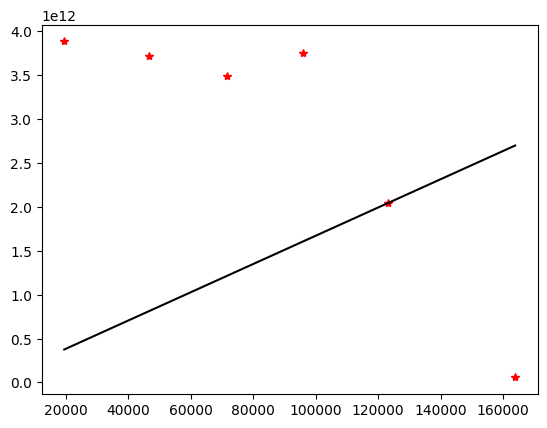

In [16]:
ok = OrdinaryKriging(lons_utm, lats_utm, values, variogram_model='linear', enable_plotting=True, enable_statistics=True)

In [17]:
# Calculate the number of grid cells in UTM coordinates
cell_size = 5000  # 5000 meters
lon_range_utm = max(lons_utm) - min(lons_utm)
lat_range_utm = max(lats_utm) - min(lats_utm)

lon_cells = int(np.ceil(lon_range_utm / cell_size))
lat_cells = int(np.ceil(lat_range_utm / cell_size))

grid_lon_utm = np.linspace(min(lons_utm), min(lons_utm) + lon_cells * cell_size, num=lon_cells)
grid_lat_utm = np.linspace(min(lats_utm), min(lats_utm) + lat_cells * cell_size, num=lat_cells)
# Estimate values and variance on the grid in UTM coordinates
z_estimated, z_variance = ok.execute('grid', grid_lon_utm, grid_lat_utm)

grid_lon_utm, grid_lat_utm = np.meshgrid(grid_lon_utm, grid_lat_utm)

# Convert the UTM grid back to lat, lon
grid_lat, grid_lon = utm_to_latlon(grid_lat_utm, grid_lon_utm)

In [18]:
river_lats = []
river_lons = []

for line in list(river_data.geometry[0].geoms)[::-1]:
    for point in line.coords:
        river_lats.append(point[1])
        river_lons.append(point[0])

start = 14000
stop = -150

river_lats = river_lats[start:stop]
river_lons = river_lons[start:stop]

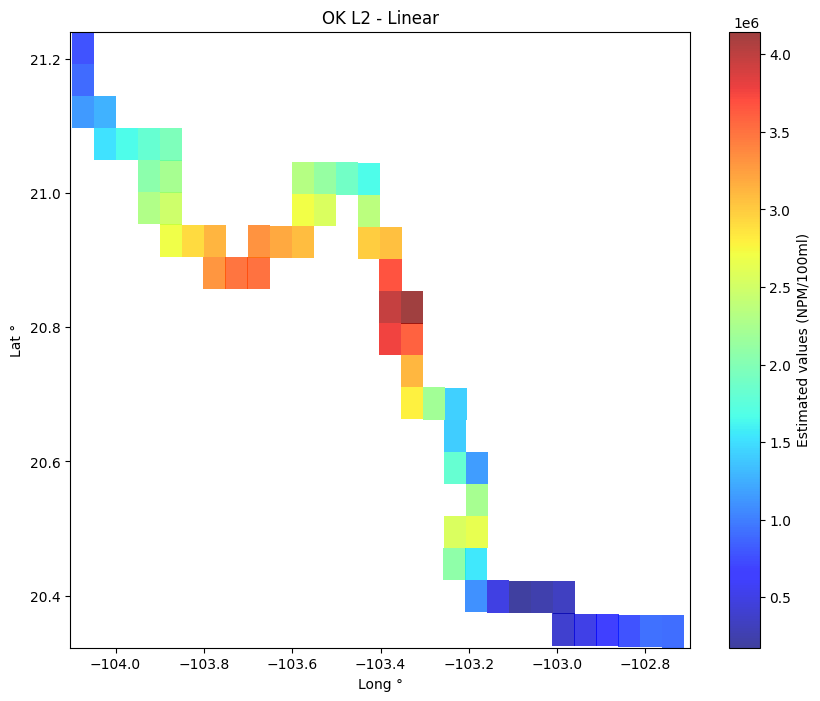

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon

# Create a LineString from river_lons and river_lats
river_line = LineString(list(zip(river_lons, river_lats)))

# Create a mask for the meshgrid based on river_line
mask = np.zeros_like(z_estimated.T, dtype=bool)

for i in range(z_estimated.shape[1]-1):
    for j in range(z_estimated.shape[0]-1):
        cell_polygon = Polygon([
            (grid_lon.T[i, j], grid_lat.T[i, j]),
            (grid_lon.T[i + 1, j], grid_lat.T[i + 1, j]),
            (grid_lon.T[i + 1, j + 1], grid_lat.T[i + 1, j + 1]),
            (grid_lon.T[i, j + 1], grid_lat.T[i, j + 1])
        ])

        mask[i, j] = not river_line.intersects(cell_polygon)

# Handle last row
for j in range(z_estimated.shape[0] - 1):
    cell_polygon = Polygon([
        (grid_lon.T[-2, j], grid_lat.T[-2, j]),
        (grid_lon.T[-1, j], grid_lat.T[-1, j]),
        (grid_lon.T[-1, j + 1], grid_lat.T[-1, j + 1]),
        (grid_lon.T[-2, j + 1], grid_lat.T[-2, j + 1])
    ])
    mask[-1, j] = not river_line.intersects(cell_polygon)

# Handle last column
for i in range(z_estimated.shape[1] - 1):
    cell_polygon = Polygon([
        (grid_lon.T[i, -2], grid_lat.T[i, -2]),
        (grid_lon.T[i + 1, -2], grid_lat.T[i + 1, -2]),
        (grid_lon.T[i + 1, -1], grid_lat.T[i + 1, -1]),
        (grid_lon.T[i, -1], grid_lat.T[i, -1])
    ])
    mask[i, -1] = not river_line.intersects(cell_polygon)

# Handle bottom right corner cell
cell_polygon = Polygon([
    (grid_lon.T[-2, -2], grid_lat.T[-2, -2]),
    (grid_lon.T[-1, -2], grid_lat.T[-1, -2]),
    (grid_lon.T[-1, -1], grid_lat.T[-1, -1]),
    (grid_lon.T[-2, -1], grid_lat.T[-2, -1])
])
mask[-1, -1] = not river_line.intersects(cell_polygon)

# Apply mask to z_estimated
z_masked = np.ma.array(z_estimated.T, mask=mask)

# Plot masked data
plt.figure(figsize=(10, 8))
plt.pcolormesh(grid_lon.T, grid_lat.T, z_masked, cmap='jet', alpha=0.75)
plt.colorbar(label='Estimated values (NPM/100ml)')
# plt.plot(river_lons, river_lats, c='red', linewidth=4)
# plt.scatter(lons, lats, c=values, edgecolors='k', cmap='jet', s=50, zorder=2)

plt.xlabel('Long °')
plt.ylabel('Lat °')
plt.title('OK L2 - Linear')
plt.show()

/home/isa/GitRepos/LACYEngine/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/isa/GitRepos/LACYEngine/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/isa/GitRepos/LACYEngine/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/isa/GitRepos/LACYEngine/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', Down

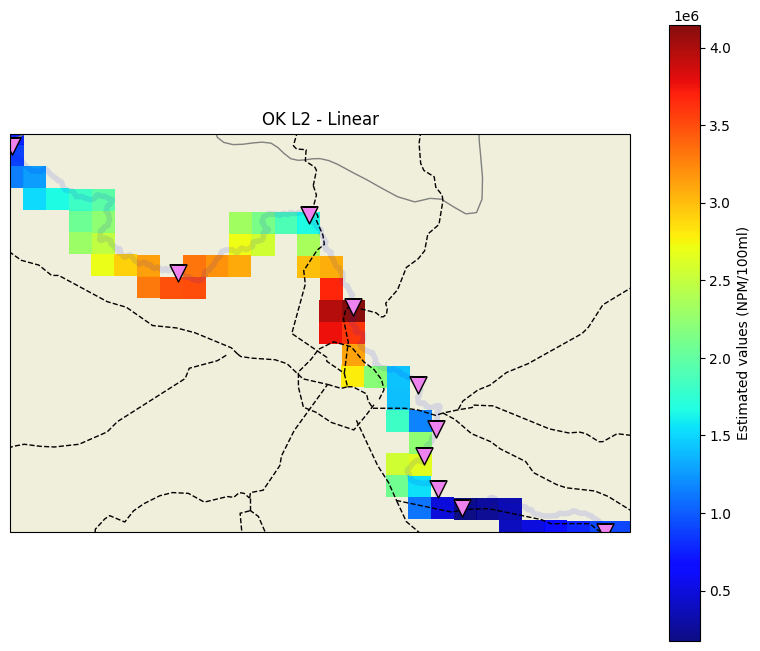

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the coordinate system
projection = ccrs.PlateCarree()

# Create the map figure
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Set the map extent based on lat-lon range
lon_min, lon_max = np.min(grid_lon), np.max(grid_lon)
lat_min, lat_max = np.min(grid_lat), np.max(grid_lat)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add high-resolution features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

roads = cfeature.NaturalEarthFeature(
    category='cultural',
    name='roads',
    scale='10m',
    facecolor='none')
ax.add_feature(roads, edgecolor='black', linestyle='--')

# Plot the masked data on the map
mesh = ax.pcolormesh(grid_lon.T, grid_lat.T, z_masked, cmap='jet', alpha=0.95, transform=projection)
plt.colorbar(mesh, ax=ax, label='Estimated values (NPM/100ml)')

ax.plot(river_lons, river_lats, c='blue', linewidth=4, transform=projection, alpha=0.10)
#scatter = ax.scatter(lons, lats, c=values, edgecolors='k', cmap='jet', s=50, zorder=2, transform=projection)
scatter = ax.scatter(lons, lats, c='violet', edgecolors='k', marker='v', s=150, zorder=2, transform=projection)

plt.xlabel('Long °')
plt.ylabel('Lat °')
plt.title('OK L2 - Linear')
plt.show()

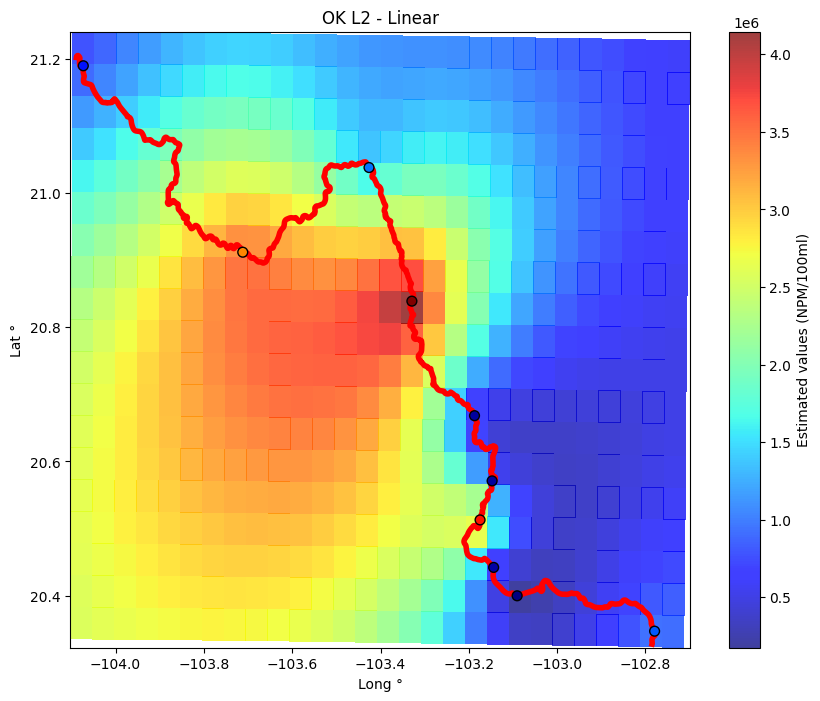

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.pcolormesh(grid_lon.T, grid_lat.T, z_estimated.T, cmap='jet', alpha=0.75)
plt.colorbar(label='Estimated values (NPM/100ml)')
plt.plot(river_lons,river_lats, c='red', linewidth=4)
plt.scatter(lons, lats, c=values, edgecolors='k', cmap='jet', s=50, zorder=2)

plt.xlabel('Long °')
plt.ylabel('Lat °')
plt.title('OK L2 - Linear')
plt.show()


/tmp/ipykernel_8275/3905532743.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('jet')


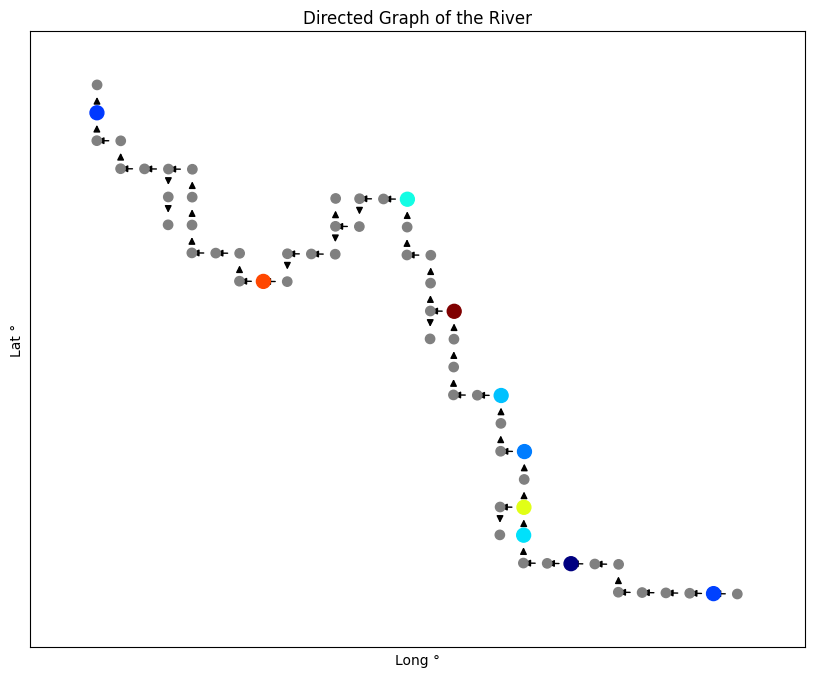

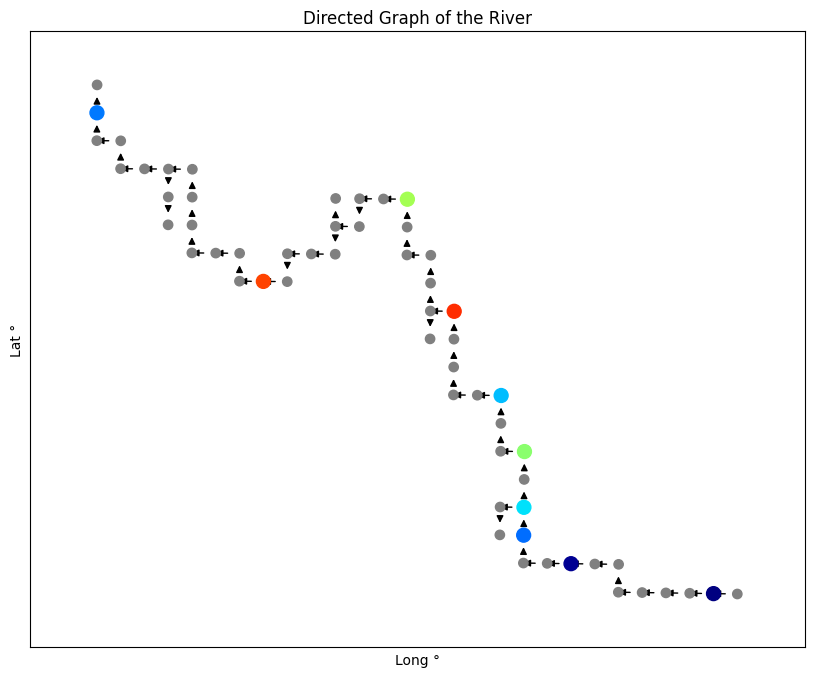

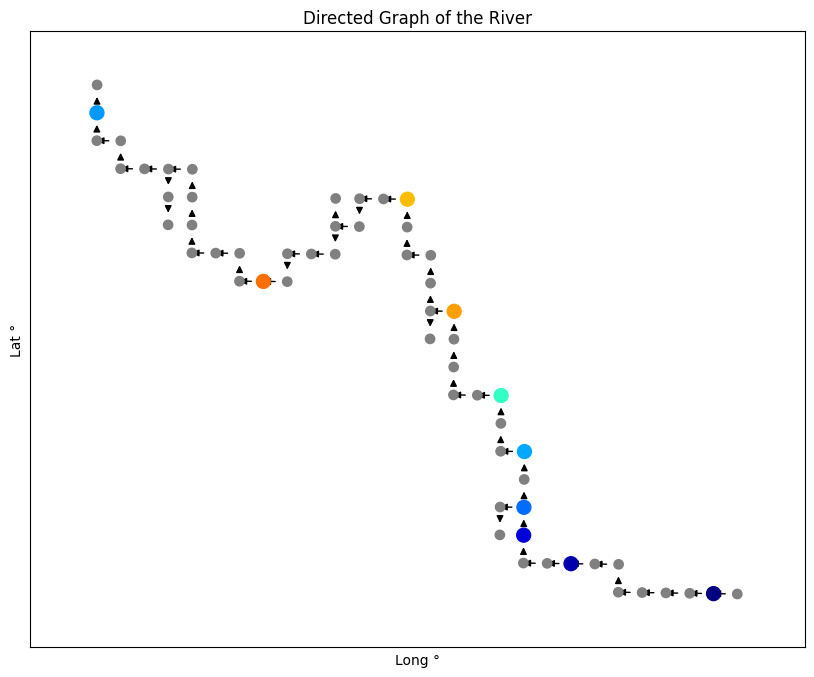

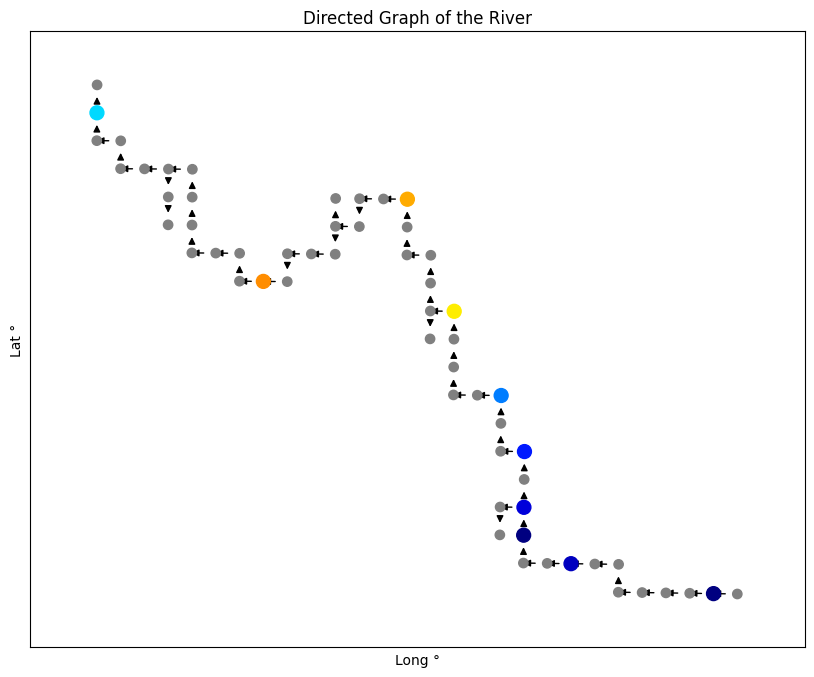

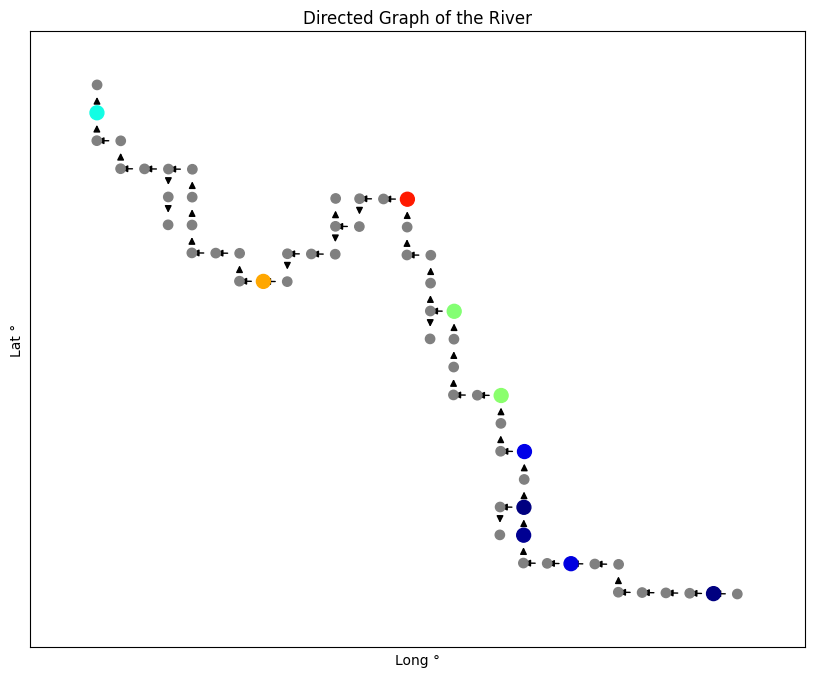

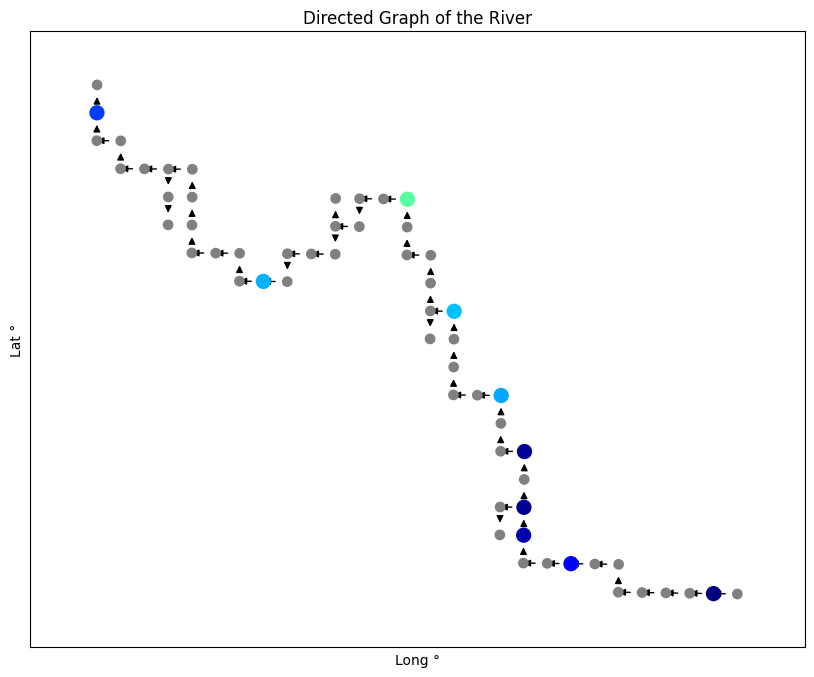

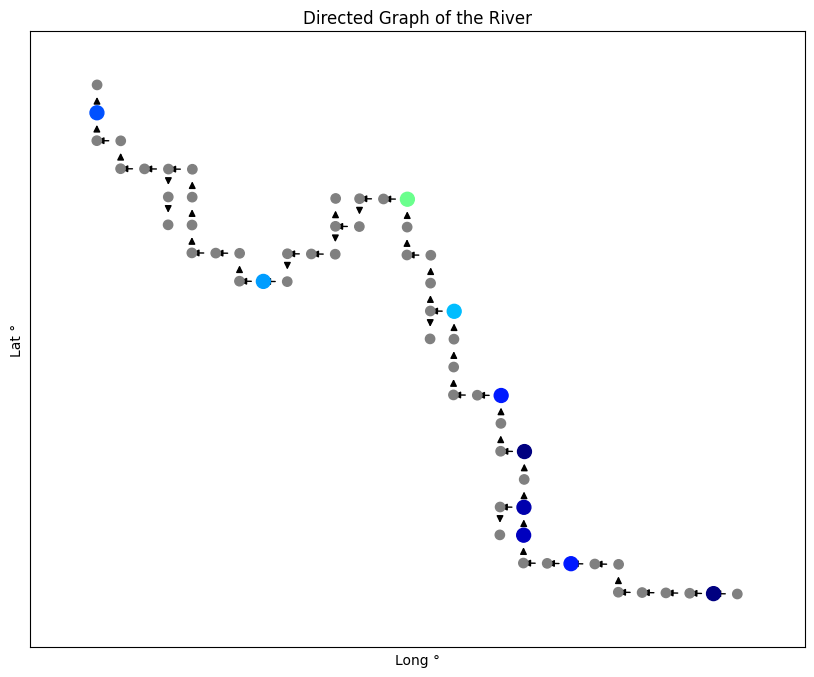

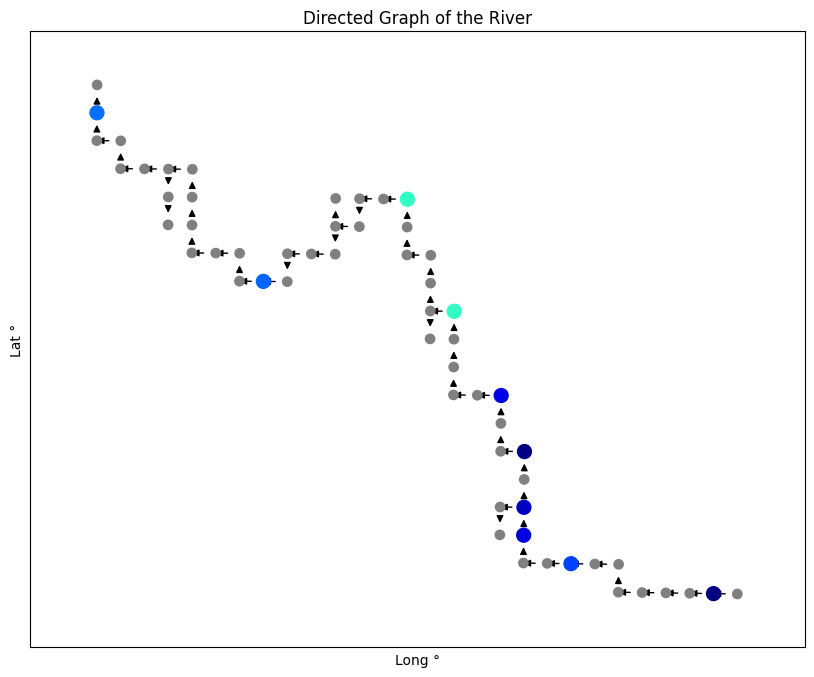

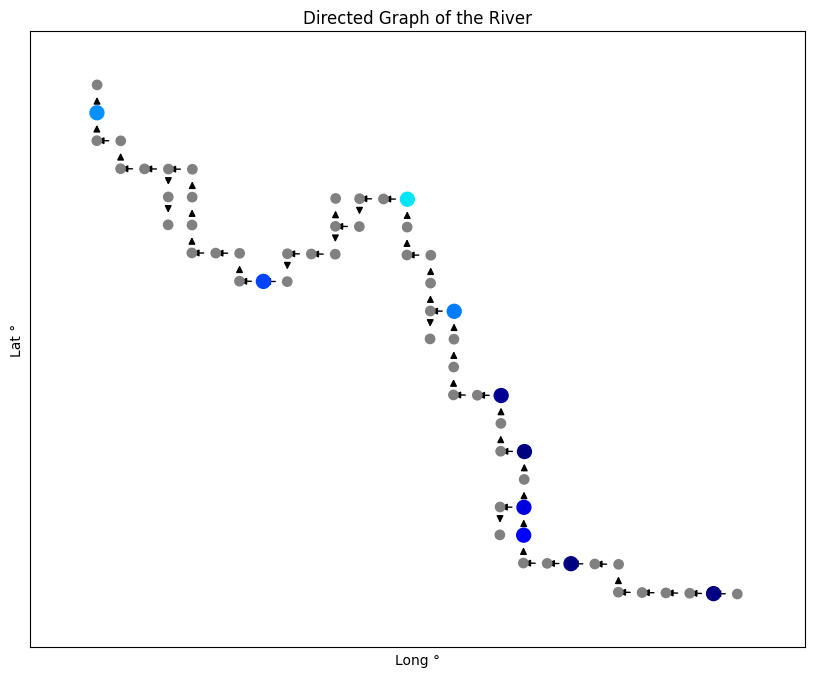

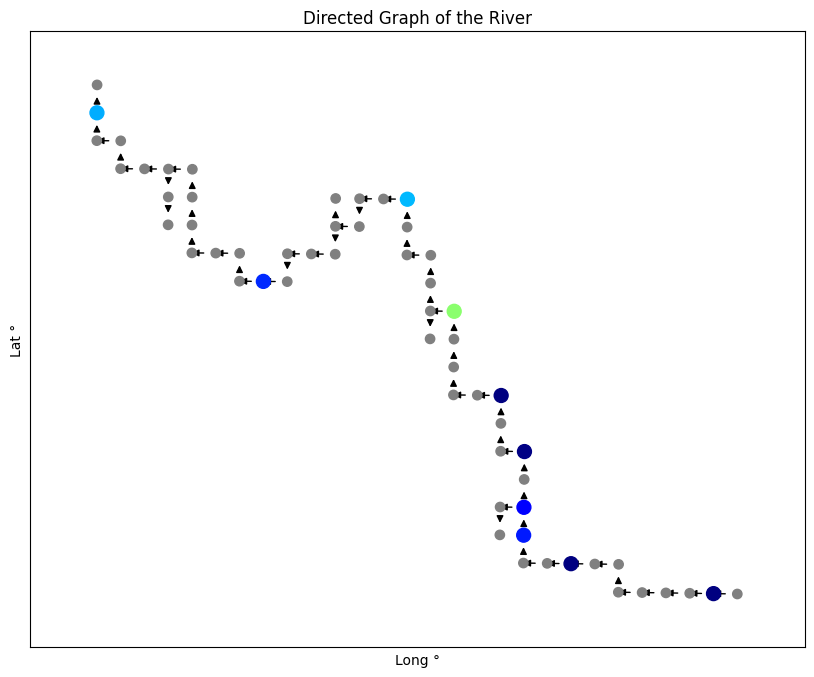

In [22]:
import networkx as nx
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def dfs(node, visited, G):
    i, j = node
    visited.add(node)
    
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor_node = (i + di, j + dj)
        if neighbor_node in G and neighbor_node not in visited:
            G.add_edge(node, neighbor_node)
            dfs(neighbor_node, visited, G)

# Create an empty graph
G = nx.DiGraph()

# Add nodes to the graph based on the mask
for i in range(z_masked.shape[0]):
    for j in range(z_masked.shape[1]):
        if not mask[i, j]:
            node = (i, j)
            G.add_node(node)

# Find the southernmost grid cell
south_node = None
min_lat = np.inf

for node in G.nodes:
    i, j = node
    lat = grid_lat.T[i, j]
    if lat < min_lat:
        min_lat = lat
        south_node = node

# Perform DFS traversal from the southernmost grid cell
visited = set()
dfs(south_node, visited, G)

monitoring_station = []
for lat, lon in zip(lats, lons):
    closest_node = None
    min_distance = np.inf
    
    for node in G.nodes:
        i, j = node
        node_lat, node_lon = grid_lat.T[i, j], grid_lon.T[i, j]
        distance = np.sqrt((node_lat - lat)**2 + (node_lon - lon)**2)
        
        if distance < min_distance:
            min_distance = distance
            closest_node = node
    
    monitoring_station.append(closest_node)

def next_state(G, val):
    new_val = {node: 0 for node in G.nodes}
    
    for node in G.nodes:
        in_edges = list(G.in_edges(node))
        out_edges = list(G.out_edges(node))
        
        # If the node has no inward edges, its value stays the same
        if not in_edges:
            new_val[node] += val[node]
        else:
            # Distribute the value equally among the adjacent nodes
            distributed_value = val[node] / len(out_edges) if out_edges else 0
            for _, neighbor_node in out_edges:
                new_val[neighbor_node] += distributed_value
                
    return new_val

pos = {node: (grid_lon.T[node], grid_lat.T[node]) for node in G.nodes}  # Define positions based on lon and lat
val = {node: z_masked[node] for node in G.nodes}

for _ in range(10):

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw the directed graph
    cmap = get_cmap('jet')
    norm = Normalize(vmin=np.nanmin(z_masked), vmax=np.nanmax(z_masked))

    #mon_s_colors = ['violet' if node in monitoring_station else cmap(norm(val[node])) for node in G.nodes]
    mon_s_colors = [cmap(norm(val[node])) if node in monitoring_station else 'gray' for node in G.nodes]
    #mon_s_colors = [cmap(norm(val[node])) for node in G.nodes]
    mon_s_sizes = [100 if node in monitoring_station else 45 for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=mon_s_colors, node_size=mon_s_sizes)
    nx.draw_networkx_edges(G, pos, ax=ax)

    # Set axis labels and title
    plt.xlabel('Long °')
    plt.ylabel('Lat °')
    plt.title('Directed Graph of the River')

    # Show the plot
    plt.show()

    val = next_state(G,val)

In [23]:
mask.data

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True

In [24]:
density_lat = []
density_lon = []
density_z = []

for i in range(z_masked.shape[0]):
    for j in range(z_masked.shape[1]):
        if not mask[i, j]:
            density_lat.append(grid_lat.T[i,j])
            density_lon.append(grid_lon.T[i,j])
            density_z.append(z_masked.data[i,j])

In [26]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set the default renderer to 'browser'
pio.renderers.default = 'browser'

# Create a subplot with mapbox
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scattermapbox'}]])

fig.add_trace(go.Densitymapbox(lat=density_lat, lon=density_lon,
                               z=density_z, colorscale='Jet', showscale=True,
                               zmin=np.min(z_masked), zmax=np.max(z_masked),
                               customdata=density_z,
                               hovertemplate='%{customdata:.2f} NPM/100ml',
                               name='Coliformes totales', radius=15), row=1, col=1)

# # Add the river data as a scattermapbox trace
# fig.add_trace(go.Scattermapbox(lat=river_lats, lon=river_lons, mode='lines',
#                                line=dict(color='red', width=4),
#                                name='River'), row=1, col=1)

# Add the scatter plot data as a scattermapbox trace
fig.add_trace(go.Scattermapbox(lat=lats, lon=lons, mode='markers',
                               marker=dict(color='violet', size=15),
                               text=values, hovertemplate='%{text:.2f} NPM/100ml',
                               name='Data Points'), row=1, col=1)

# Set the mapbox configuration
fig.update_layout(mapbox=dict(style='open-street-map', zoom=10,
                              center=dict(lat=np.mean([lat_min, lat_max]),
                                          lon=np.mean([lon_min, lon_max]))),
                  title='OK L2 - Linear',
                  margin=dict(l=20, r=20, t=80, b=20))

# Show the figure
fig.show()